In [1]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc import adia_analysis
from Circuit_Simulator._util import *
from Circuit_Simulator.Qobj import *

In [2]:
# x=np.linspace(-10,10,1000)
# np.sinc(x)
# plt.plot(x,np.sinc(x))

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '8200.0MHz', 'Q2_anhar': '-150.0MHz', 'Q3_freq': '5400.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '126.2569MHz', 'g13': '8.5381MHz', 'g23': '119.7778MHz'}


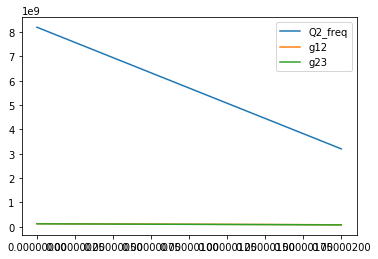

In [2]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='basis',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(0/7.2,5/7.2,2001)
freq_array = 8.2e9-flux_pulse * (8.2e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.00e9)
raw_config.setValue('Q2 f01_max',8.2e9)
raw_config.setValue('Q3 f01_max',5.4e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.3e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.018)
raw_config.setValue('r23',0.018)
raw_config.setValue('r13',0.0015)

raw_config.setValue('Q2 Voltage period',-1)
raw_config.setValue('Q2 Voltage operating point',0.00)
raw_config.setValue('Q2 Flux',flux_pulse)


simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

In [3]:
def get_transmon_freq(f01_max,f01_min,Ec,Voltage_Period,Voltage_operating_point,flux):
    if Voltage_Period >= 0:
        Ej_max = (f01_max + Ec)**2/(8*Ec)
        d = (f01_min + Ec)**2/(8*Ec*Ej_max)
        phi = (Voltage_operating_point + flux)/ Voltage_Period
        # self.config.log('d',d)
        # self.config.log('Ej_max',phi)
        Ej_flux = Ej_max * np.sqrt( np.cos(np.pi * phi)**2 + np.sin(np.pi*phi)**2 * d**2)

        freq= np.sqrt(8*Ej_flux * Ec) -Ec
    else:
        freq = (f01_min-f01_max) * flux + f01_max
    anhar = -1 * Ec
    return freq,anhar

In [4]:
Simulator.performsimulation(solver_type=2,resample_factor=1,get_cloest_eigen=False,sort_by_maximum_overlap=True,gap=10e6)

In [5]:
eigenstate010 = Simulator.EigenResult.eigen_state[:,3]
eigenstate100 = Simulator.EigenResult.eigen_state[:,9]
eigenstate001 = Simulator.EigenResult.eigen_state[:,1]

eigenstate101 = Simulator.EigenResult.eigen_state[:,10]
eigenstate011 = Simulator.EigenResult.eigen_state[:,4]
eigenstate110 = Simulator.EigenResult.eigen_state[:,12]
eigenstate002 = Simulator.EigenResult.eigen_state[:,2]
eigenstate020 = Simulator.EigenResult.eigen_state[:,6]
eigenstate200 = Simulator.EigenResult.eigen_state[:,18]

In [24]:
flux_pulse = np.linspace(0,0.4,1001)
df_dphi_arr = ( get_transmon_freq(8.2e9,1e9,300e6,1,0,flux_pulse+10e-6)[0]-get_transmon_freq(8.2e9,1e9,300e6,1,0,flux_pulse+0e-6)[0] )/ 10e-6
freq_arr = get_transmon_freq(8.2e9,1e9,300e6,1,0,flux_pulse+0e-6)[0]
spline = adia_analysis.get_Bsline(freq_arr[::-1],df_dphi_arr[::-1])
d_omegac_d_phi_square = adia_analysis.get_interpolate_value(spline,freq_array[:-1])**2

# plt.plot(freq_array[:-1],d_omegac_d_phi_square)

df = freq_array[0] - freq_array[1]
def get_leakage_factor(main_trace_index,leakage_trace_index,df):
#     df = 5e6
    eigenstate_main = Simulator.EigenResult.eigen_state[:,main_trace_index]
    eigenstate_leak = Simulator.EigenResult.eigen_state[:,leakage_trace_index]
    eigenener_main = Simulator.EigenResult.eigen_ener[:,main_trace_index]
    eigenener_leak= Simulator.EigenResult.eigen_ener[:,leakage_trace_index]
    
    eigenstate_main_smooth = adia_analysis.smooth_state_trace(eigenstate_main)
    eigenstate_main_deriv = (eigenstate_main_smooth[1:]-eigenstate_main_smooth[0:-1])/df
    
    leak_main_to_leak = []
    for i in range(len(eigenstate_main_deriv)):
        leak_main_to_leak.append(  abs(eigenener_main[i]-eigenener_leak[i])**2 * ( np.dot(eigenstate_leak[i].T,eigenstate_main_deriv[i]) )**2  )
        
    return np.array(leak_main_to_leak)

def S_w(A,w_gap):
    return np.abs(A/w_gap)

def get_Gamma(A,main_trace_index,leakage_trace_index,df,d_omegac_d_phi_square,EigenResult):
    return get_leakage_factor(main_trace_index,leakage_trace_index,df)*d_omegac_d_phi_square*S_w(A,EigenResult.eigen_ener[0:len(d_omegac_d_phi_square),main_trace_index]-EigenResult.eigen_ener[0:len(d_omegac_d_phi_square),leakage_trace_index])

In [7]:
A = (40e-6)**2
df = freq_array[0] - freq_array[1]
Gamma_001_010 = get_Gamma(A,1,3,df,d_omegac_d_phi_square,Simulator.EigenResult)
Gamma_100_010 = get_Gamma(A,9,3,df,d_omegac_d_phi_square,Simulator.EigenResult)
Gamma_100_001 = get_Gamma(A,9,1,df,d_omegac_d_phi_square,Simulator.EigenResult)

Gamma_101_002 = get_Gamma(A,10,2,df,d_omegac_d_phi_square,Simulator.EigenResult)
Gamma_101_020 = get_Gamma(A,10,6,df,d_omegac_d_phi_square,Simulator.EigenResult)
Gamma_101_200 = get_Gamma(A,10,18,df,d_omegac_d_phi_square,Simulator.EigenResult)
Gamma_101_011 = get_Gamma(A,10,4,df,d_omegac_d_phi_square,Simulator.EigenResult)
Gamma_101_110 = get_Gamma(A,10,12,df,d_omegac_d_phi_square,Simulator.EigenResult)

C:\Users\tsuji\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


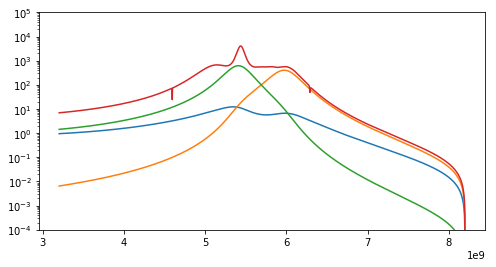

In [8]:
fig=plt.figure(figsize=[8,4])
ax=fig.add_subplot(111)
ax.plot(freq_array[0:-1],Gamma_001_010/1e0)
ax.plot(freq_array[0:-1],Gamma_100_010/1e0)
ax.plot(freq_array[0:-1],Gamma_100_001/1e0)

plt.plot(freq_array[0:-1],(Gamma_101_002+Gamma_101_020+Gamma_101_020+Gamma_101_011+Gamma_101_110)/1e0 )
# ax.plot(freq_array[0:-1],Gamma_101_020/1e6)
# ax.plot(freq_array[0:-1],Gamma_101_200/1e6)
# ax.plot(freq_array[0:-1],Gamma_101_011/1e6)
# ax.plot(freq_array[0:-1],Gamma_101_110/1e6)

ax.set_ylim([1e-4,1e5])
ax.set_yscale('log')

## Gamma_phi

In [ ]:
sigma_flux  = 100e-6

adia_analysis.get_interpolate_value(spline,freq_array[:-1])*sigma_flux/np.sqrt(2)


## T1

In [9]:
import qutip as qt
lambda_coupler = 2.5e-3
lambda_q1 = 2.5e-3
lambda_q2 = 2.5e-3
kB = 1.380649*10**(-23)
Hbar = 6.62607015*10**(-34) 

def get_T1(mat_factor,f,Temper=0.02):
    heat_parameter =0.5*( 1/np.tanh(Hbar*f/(kB*Temper)) +1 )
    return 1/(mat_factor**2*f*heat_parameter)

def get_T1_Gamma(mat_factor,f,Temper=0.02):
#     if f>0:
#         return mat_factor**2*6e9
#     else:
#         return 0
    heat_parameter =0.5*( 1/np.tanh(Hbar*f/(kB*Temper)) +1 )
    return mat_factor**2*f*heat_parameter

def get_operator(lambda_q1,lambda_q2,lambda_coupler):
    a1_a =qt.tensor( lambda_q1 * ( qt.create(3)+ qt.destroy(3) ),qt.qeye(3),qt.qeye(3)  )
    ac_a =qt.tensor( qt.qeye(3), lambda_coupler * ( qt.create(3)+ qt.destroy(3)),qt.qeye(3)  )
    a2_a =qt.tensor( qt.qeye(3),qt.qeye(3),lambda_q2 * (qt.create(3)+qt.destroy(3))  )
    
    return Qflatten(a1_a+a2_a+ac_a)

In [10]:
def get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,estate_trace,ener_trace,central_idx,leak_idx):
    leak_oper1 = get_operator( lambda_q1,lambda_q2*0,lambda_coupler*0 )
    leak_oper2 = get_operator( lambda_q1*0,lambda_q2,lambda_coupler*0 )
    leak_oper3 = get_operator( lambda_q1*0,lambda_q2*0,lambda_coupler )
    gamma_arr=[]
    for i in range(len(estate_trace[:,0])):

        gamma1 = get_T1_Gamma( (qt.Qobj(estate_trace[i][leak_idx]).dag()* (leak_oper1*qt.Qobj(estate_trace[i][central_idx])))[0][0][0]  , ener_trace[i][central_idx]-ener_trace[i][leak_idx] )
        gamma2 = get_T1_Gamma( (qt.Qobj(estate_trace[i][leak_idx]).dag()* (leak_oper2*qt.Qobj(estate_trace[i][central_idx])))[0][0][0]  , ener_trace[i][central_idx]-ener_trace[i][leak_idx] )
        gamma3 = get_T1_Gamma( (qt.Qobj(estate_trace[i][leak_idx]).dag()* (leak_oper3*qt.Qobj(estate_trace[i][central_idx])))[0][0][0]  , ener_trace[i][central_idx]-ener_trace[i][leak_idx] )

        gamma_arr.append( np.real(gamma1)+np.real(gamma2)+np.real(gamma3) )
    return np.array(gamma_arr)

In [11]:
# Simulator.performsimulation(solver_type=2,resample_factor=1,get_cloest_eigen=False,sort_by_maximum_overlap=True,gap=10e6)

In [12]:
Decay_001_000 = get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,Simulator.EigenResult.eigen_state,Simulator.EigenResult.eigen_ener,1,0  )
Decay_100_000 = get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,Simulator.EigenResult.eigen_state,Simulator.EigenResult.eigen_ener,9,0  )

# Decay_101_000 = get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,Simulator.EigenResult.eigen_state,Simulator.EigenResult.eigen_ener,10,0  )
Decay_101_010 = get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,Simulator.EigenResult.eigen_state,Simulator.EigenResult.eigen_ener,10,3  )
Decay_101_100 = get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,Simulator.EigenResult.eigen_state,Simulator.EigenResult.eigen_ener,10,9  )
Decay_101_001 = get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,Simulator.EigenResult.eigen_state,Simulator.EigenResult.eigen_ener,10,1  )

# Decay_101_011 = get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,Simulator.EigenResult.eigen_state,Simulator.EigenResult.eigen_ener,10,4  )


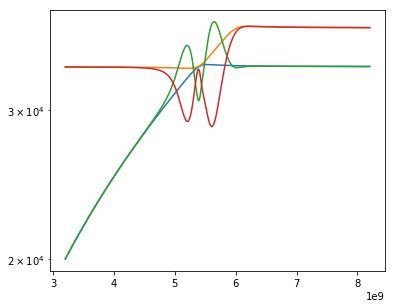

In [13]:
fig=plt.figure(figsize=[6,4.8])
ax=fig.add_subplot(111)
ax.plot(freq_array,Decay_001_000/1e0)
ax.plot(freq_array,Decay_100_000/1e0)

# ax.plot(freq_array,Decay_101_010/1e0)
ax.plot(freq_array,Decay_101_100/1e0)
ax.plot(freq_array,Decay_101_001/1e0)

# ax.set_ylim([1e-8,0.1])
ax.set_yscale('log')

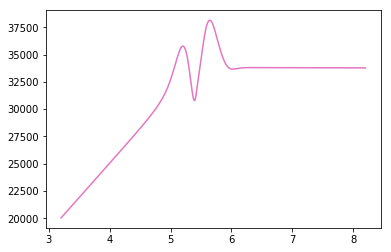

In [14]:

plt.plot(freq_array/1e9,Decay_101_100/1e0,label='101_decay_100',c='tab:pink')

In [15]:
Gamma_101_leakage= (Gamma_101_002+Gamma_101_020+Gamma_101_020+Gamma_101_011+Gamma_101_110)

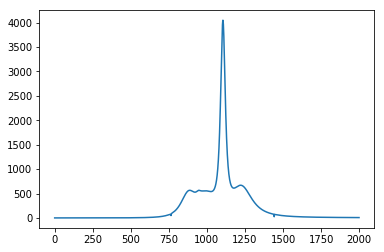

In [16]:
plt.plot(Gamma_101_leakage)

In [17]:
Gamma_101_leakage[442]=Gamma_101_leakage[441]
Gamma_101_leakage[781]=Gamma_101_leakage[780]

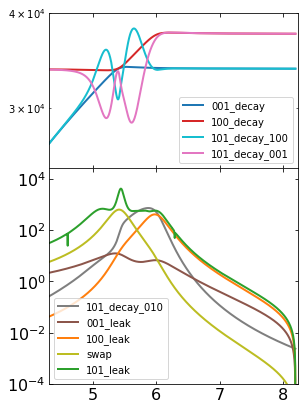

In [18]:
fig=plt.figure(figsize=[4.8,6])
ax1 = fig.add_axes([0.15,0.6,0.72,0.36])
ax2 = fig.add_axes([0.15,0.10,0.72,0.5])

start=0
end = 1800
lw=2
ax1.plot(freq_array[start:end]/1e9,Decay_001_000[start:end]/1e0,label='001_decay',c='tab:blue',linewidth = lw)
ax1.plot(freq_array[start:end]/1e9,Decay_100_000[start:end]/1e0,label='100_decay',c='tab:red',linewidth = lw)


ax1.plot(freq_array[start:end]/1e9,Decay_101_100[start:end]/1e0,label='101_decay_100',c='tab:cyan',linewidth = lw)
ax1.plot(freq_array[start:end]/1e9,Decay_101_001[start:end]/1e0,label='101_decay_001',c='tab:pink',linewidth = lw)


ax2.plot(freq_array[start:end]/1e9,Decay_101_010[start:end]/1e0,label='101_decay_010',c='tab:gray',linewidth = lw)

ax2.plot(freq_array[start:end]/1e9,Gamma_001_010[start:end]/1e0,label='001_leak',c='tab:brown',linewidth = lw)
ax2.plot(freq_array[start:end]/1e9,Gamma_100_010[start:end]/1e0,label='100_leak',c='tab:orange',linewidth = lw)
ax2.plot(freq_array[start:end]/1e9,Gamma_100_001[start:end]/1e0,label='swap',c='tab:olive',linewidth = lw)
# ax2.plot(freq_array[start:end]/1e9,(Gamma_101_002+Gamma_101_020+Gamma_101_020+Gamma_101_011+Gamma_101_110)[start:end]/1e0,label='101_leak',c='tab:green',linewidth = lw)

ax2.plot(freq_array[start:end]/1e9,Gamma_101_leakage[start:end]/1e0,label='101_leak',c='tab:green',linewidth = lw)


ax1.set_ylim([2.5e4,4e4])
ax2.set_ylim([1e-4,2.5e4])

ax1.set_xlim([4.3,8.24])
ax2.set_xlim([4.3,8.24])

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.legend()
ax2.legend()

ax1.tick_params(axis='x',which='both',top=True,bottom=True,direction='in' )
ax1.tick_params(axis='y',which='both',left=True,right=True,direction='in' )
ax2.tick_params(axis='x',which='both',top=True,bottom=True,direction='in' )
ax2.tick_params(axis='y',which='both',left=True,right=True,direction='in' )

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

In [20]:
transmon = PG.Transmon(8.2e9, 1e9, 300e6, 1, 0, 0)

In [22]:
flux_scan = transmon.df_to_dV(freq_array[start:end]-8.2e9)

C:\Users\tsuji\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


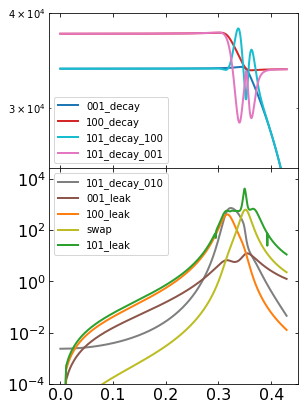

In [23]:
fig=plt.figure(figsize=[4.8,6])
ax1 = fig.add_axes([0.15,0.6,0.72,0.36])
ax2 = fig.add_axes([0.15,0.10,0.72,0.5])

start=0
end = 1800
lw=2
ax1.plot(flux_scan,Decay_001_000[start:end]/1e0,label='001_decay',c='tab:blue',linewidth = lw)
ax1.plot(flux_scan,Decay_100_000[start:end]/1e0,label='100_decay',c='tab:red',linewidth = lw)


ax1.plot(flux_scan,Decay_101_100[start:end]/1e0,label='101_decay_100',c='tab:cyan',linewidth = lw)
ax1.plot(flux_scan,Decay_101_001[start:end]/1e0,label='101_decay_001',c='tab:pink',linewidth = lw)


ax2.plot(flux_scan,Decay_101_010[start:end]/1e0,label='101_decay_010',c='tab:gray',linewidth = lw)

ax2.plot(flux_scan,Gamma_001_010[start:end]/1e0,label='001_leak',c='tab:brown',linewidth = lw)
ax2.plot(flux_scan,Gamma_100_010[start:end]/1e0,label='100_leak',c='tab:orange',linewidth = lw)
ax2.plot(flux_scan,Gamma_100_001[start:end]/1e0,label='swap',c='tab:olive',linewidth = lw)

ax2.plot(flux_scan,Gamma_101_leakage[start:end]/1e0,label='101_leak',c='tab:green',linewidth = lw)


ax1.set_ylim([2.5e4,4e4])
ax2.set_ylim([1e-4,2.5e4])

# ax1.set_xlim([4.3,8.24])
# ax2.set_xlim([4.3,8.24])

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.legend()
ax2.legend()

ax1.tick_params(axis='x',which='both',top=True,bottom=True,direction='in' )
ax1.tick_params(axis='y',which='both',left=True,right=True,direction='in' )
ax2.tick_params(axis='x',which='both',top=True,bottom=True,direction='in' )
ax2.tick_params(axis='y',which='both',left=True,right=True,direction='in' )

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

In [24]:
np.sqrt(np.pi/9/np.log(10))*100

38.935507271524465

In [30]:
np.sqrt(6*np.log(10)*40**2/np.pi)

83.8819512722642